In [1]:
# General Idea:
# /content/gdrive/My Drive/Colab Notebooks/

# Plan
# 1. Add Background to Image dependent on image size (choose from x different backgrounds)
# 2. Add some more distortions
# 3. Rotate and sheer image
# 4. Rescale images to fixed size.
# 5. Write as generator
# 6. Write CNN which predicts 2 angles

In [ ]:
# colab specific stuff
!pip install pillow
!pip install --upgrade imgaug
!pip install -U -q PyDrive

In [182]:
from PIL import Image
import random
import numpy as np
import cv2
import os

import imgaug as ia
print(ia.__version__)
from imgaug import augmenters as iaa

%matplotlib inline
from matplotlib import pyplot as plt

0.2.7


# Get Data

In [183]:
input_data_folder = "invoice_img_data"
background_img_folder = "background_img"
invoices_with_background_folder = "img_with_background"

In [650]:
# https://mikulskibartosz.name/how-to-load-data-from-google-drive-to-pandas-running-in-google-colaboratory-a7f6a033c997
# nali.org/load-google-drive-csv-panda-dataframe-google-colab/
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

ModuleNotFoundError: No module named 'pydrive'

In [4]:
drive = GoogleDrive(gauth) # Create GoogleDrive instance with authenticated GoogleAuth instance
file_list = drive.ListFile({'q': "'1MI8PBiqNT-o6m0xYV8JYHUkqaqfTKkz2' in parents and trashed=false"}).GetList()
for file1 in file_list:
    print('title: %s, id: %s' % (file1['title'], file1['id']))

invoice_img_folder_id = "1lf4Ln_P_bFI5ZqZL4Cfr5-uVFPHoUjj5"
background_img_folder_id = "1Gr9uJWxANEapNSovT8cP--QUzWeTv5Pw"
invoices_with_background_folder_id = ""

title: invoice_img_data, id: 1lf4Ln_P_bFI5ZqZL4Cfr5-uVFPHoUjj5
title: background_img, id: 1Gr9uJWxANEapNSovT8cP--QUzWeTv5Pw
title: gen_invoices_labels_100k.csv, id: 1727tj-xC0LJUZ77N2AdIyQWNJX7jKj1x


In [0]:
def create_folder_get_data(folder_id, folder_name):
    # create data folder
    try:
        os.mkdir(folder_name)
    except FileExistsError:
        print("%s folder already created!" % folder_name)

    os.chdir(folder_name)

    file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
    file_list = [x for x in file_list if "label" not in x['title']]#[:30]

    for i, file1 in enumerate(sorted(file_list, key = lambda x: x['title'])):
        print('Downloading {} from GDrive ({}/{})'.format(file1['title'], i, len(file_list)))
        file1.GetContentFile(file1['title'])

    os.chdir("..")

In [0]:
# create_folder_get_data(invoice_img_folder_id, input_data_folder)

In [ ]:
# create_folder_get_data(invoices_with_background_folder_id, invoices_with_background_folder)

In [0]:
# create_folder_get_data(background_img_folder_id, background_img_folder)

In [185]:
!ls invoice_img_data

01062018_factory_berlin_invoice_RBS-20188141.png
01072018_factory_berlin_invoice_RBS-20189441.png
20170109_Flug_Wien_Fabian.png
20170427_Rechnung_ES5WHNF_Easyjet.png
20170507_RE0475380.png
20170607_Rechnung_KDVZ66_AUA_VIE_-_LIS_-_VIE.png
20170628_Rechnung_KN4N6P_Airberlin.png
20170710_Rechnung_ESJNFXN_Easyjet.png
20170711_Rechnung_ESJNKDZ_Easyjet_VIE-GVA.png
20170715_Flug_Lissabon.png
20170716_Udacity_Frontend_Fabian.png
20170726_Flug_Wien_Fabian.png
20170728_Udacity_React_Fabian.png
20170810_RE0499837.png
20170812_Rechnung_QZKNIO_Airberlin.png
20170817_Udacity_Frontend_Fabian.png
20170821_Bus_Berlin_Fabian.png
20170821_RE0502624.png
20170823_Rechnung_Easyjet_GVA_SFX.png
20170901_Rechnung_OVO7NI_Airberlin.png
20170907_Sixt_Automiete_Fabian.png
20170908 City Parkhaus.png
20170909 Tankstelle Scall.png
20170909_1&1_Internet_SE_Domain_RG100040835576.png
20170910_Rechnung_ESSTB5V_Easyjet.png
20170910_Rechnung_SVMWO8_AUA.png
20170911_factory_berlin_invoice_RBS-20179807.png
20170915_Flug_Mün

In [184]:
!ls img_with_background

20170825 Lugano Servizi.JPG
20170827 Lugano Bus.JPG
20170915 Saturn.JPG
20170916 YamYam.JPG
20170918 McPaper AG.JPG
20170919 Edeka.JPG
20170921 Shiso Burger.JPG
20170924 MVG.JPG
20170925 Augustiner am Dom (2).JPG
20170925 Augustiner am Dom.JPG
20170926 Bärenwirt (1).JPG
20170926 Bärenwirt.JPG
20170927 Henry am Zug.JPG
20171001 Wienerlinen - 24h Wien Ticket.JPG
20171021 World of Pizza.JPG
20171023 Amazon.JPG
20171025 Wiener Linien.JPG
20171025 ÖBB.JPG
20171026 Vietnam Bistro.JPG
20171027 City Airport Train Wien Pranay.JPG
20171027 Mytaxi Pranay.JPG
20171028 Fladerei.JPG
20171028 Wiener Linien (1).JPG
20171028 Wiener Linien.JPG
20171030 Berlin Lisbon Pranay.JPG
20171030 Känguruh Pub (1).JPG
20171030 Känguruh Pub.JPG
20171104 Lissabon Öffis.JPG
20171106 Lisbon Öffis.JPG
20171107 Lisbon Öffis (1).JPG
20171107 Lisbon Öffis.JPG
20171109 Restaurante Alfaia.JPG
20171111 YamYam.JPG
20171114 Handelsregistereintrag.JPG
20171118 Tiroler Bauernstuben.JPG
20171120 Deutsche Post.JPG
20171120 Vina X

In [186]:
!ls background_img

1538846.jpg
33971803-potted-grass-flower-over-wooden-table-background-with-copy-space.jpg
43581859-succulent-in-pot-wooden-table-background-with-copy-space.jpg
79876024-abstract-surface-white-wood-table-texture-background-close-up-of-dark-rustic-wall-made-of-white-wood.jpg
81915338-abstract-rustic-surface-white-wood-table-texture-background-close-up-of-rustic-wall-made-of-white-wo.jpg
93268346-white-background-wooden-table-surface-texture-planks-close-up.jpg
Dark-Grey-Background-Texture-10.jpg
Table-Top-Background-1.png
Table_surface.jpg
abstract-light-grey-background-vector-13747865.jpg
f50524ee5f161f437400aaf215c9e12f.jpg
hazelnut-falling-on-a-wooden-table-on-a-black-background-slow-motion-close-up_rahktoix__F0000.png
images.jpg
images1.jpg
images2.jpg
index.jpg
index1.png
mobile-phone-with-blank-screen-on-wooden-table-background-top-view-with-copy-space_1253-984.jpg
pexels-photo-242236.jpeg
pouring-of-lentils-on-white-background-this-video-was-shoot-using-custom-light-set-up-with-ad

In [187]:
max_img_size_x = 300
max_img_size_y = 400
scaler = 2
max_rotation = 45
max_shear = 0

# Augmentation

In [188]:
def add_background_img(foreground, background, max_img_size_x, max_img_size_y, scaler):
    width = foreground.size[0]
    height = foreground.size[1]
#     print(width, height)

    if(width > height):
        max_size = int(width*scaler)
    else:
        max_size = int(height*scaler)

    y_size = int(max_size*max_img_size_y/max_img_size_x)
    foreground = foreground.resize((int(width), int(height)), Image.ANTIALIAS)
    background = background.resize((max_size, y_size), Image.ANTIALIAS)

    margin_w = int((background.size[0]-foreground.size[0])/2)
    margin_h = int((background.size[1]-foreground.size[1])/2)

    # foreground.show()
    background.paste(foreground, (margin_w, margin_h))
#     background.show()

    return background

In [189]:
def augment_img(foreground, background, scaler, max_rotation, max_shear, no_background=False):
    # load image with background
    if(no_background):
        background_scaler = random.uniform(1.0, 1.2)
    else:
        background_scaler = scaler
    open_cv_image = np.array(add_background_img(foreground, background, max_img_size_x,
                                            max_img_size_y, background_scaler).convert('RGB'))

    # Convert RGB to BGR
    open_cv_image = open_cv_image[:, :, ::-1].copy() 

    # define augmentations
    rotation = random.randint(-max_rotation,max_rotation)
    shear = random.randint(-max_shear, max_shear)

    # 2. Add some more distortions
#     blur_aug = ia.augmenters.blur.MotionBlur(k=(3,4), angle=(0, 360), direction=(-1.0, 1.0))
    
    # 3. Rotate and sheer image
    rotate_aug = ia.augmenters.geometric.Affine(rotate=rotation)
    shear_aug = ia.augmenters.geometric.Affine(shear=shear)
    
    # exectue augmentation
    new_img = rotate_aug.augment_image(open_cv_image)
#     new_img = blur_aug.augment_image(new_img)
    new_img = shear_aug.augment_image(new_img)

    # show
    img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
#     img.show()

    # crop image
    if(no_background):
        crop_scaler = scaler/1.3
    else:
        crop_scaler = scaler/random.uniform(0.8, 1.3)
            
    crop_side_percentage = (crop_scaler-1)/(2*crop_scaler)

    area = (
        img.size[0]*crop_side_percentage, # width left
        img.size[1]*crop_side_percentage, # height top
        img.size[0]*(1-crop_side_percentage), # width right
        img.size[1]*(1-crop_side_percentage), # height bottom
    )
    cropped_img = img.crop(area)
#     cropped_img.show()
    
    return cropped_img, rotation, shear

In [190]:
def img_show(img, figsz=12, cv=False):
    fig=plt.figure(figsize=(figsz, figsz), dpi= 40, facecolor='w', edgecolor='k')
    if(cv): # convert to cv2 if image is not cv2
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    return None

In [191]:
input_img_names = [
    x for x in os.listdir(input_data_folder) if "_label" not in x and (
        ".JPG" in x or ".jpg" in x or ".png" in x)]
background_img_names = [
    x for x in os.listdir(background_img_folder) if "_label" not in x and ".png" in x or ".jpg" in x or ".jpeg" in x]

-12 0


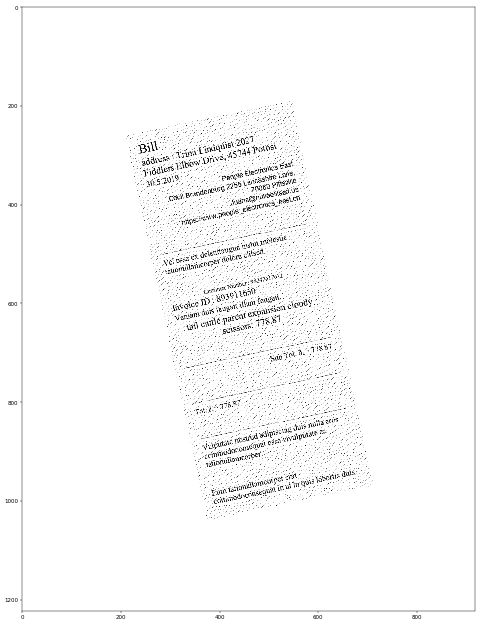

In [192]:
# test augmentation
img_name = random.choice(input_img_names)
background_name = random.choice(background_img_names)

foreground = Image.open(os.path.join(input_data_folder, img_name))
background = Image.open(os.path.join(background_img_folder, background_name))

curr_img, rotation, shear = augment_img(foreground, background,
                                        scaler, max_rotation, max_shear)
img_show(curr_img, 20)
print(rotation, shear)

In [193]:
invoices_with_background_names = [
    x for x in os.listdir(invoices_with_background_folder) if ".JPG" in x or ".jpg" in x or ".png" in x]

27 0


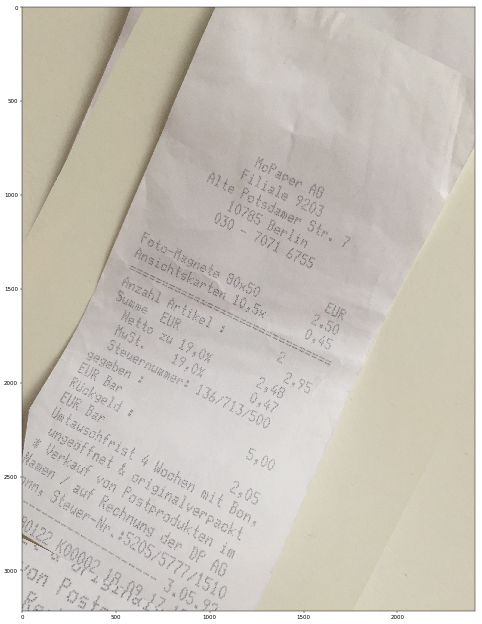

In [194]:
# test augmentation
img_name = random.choice(invoices_with_background_names)

foreground = Image.open(os.path.join(invoices_with_background_folder, img_name))
curr_img, rotation, shear = augment_img(foreground, foreground,
                                        scaler, max_rotation, max_shear, True)
img_show(curr_img, 20)
print(rotation, shear)

In [195]:
print("artificial invoices and real invoices no background %i\nreal invoices with background %i\nbackground images %i\n" % (
    len(input_img_names),
    len(invoices_with_background_names),
    len(background_img_names)))

artificial invoices and real invoices no background 220
real invoices with background 63
background images 32



# Model + Training

In [196]:
# !!pip uninstall torch
!pip install -q torch==1.0.0 torchvision
!pip install wandb

You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [197]:
from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder
from numpy import argmax

import torch
print(torch.__version__)
from torch import nn
import torch.backends.cudnn as cudnn

# https://stackoverflow.com/questions/42480111/model-summary-in-pytorch
# from torchsummary import summary

# https://github.com/lanpa/tensorboardX
# from tensorboardX import SummaryWriter
# writer = SummaryWriter("logs/image_rotation")

import wandb

1.0.0


In [198]:
import torchvision

import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import time

In [203]:
use_gpu = False
device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

In [204]:
# preperation for saving model
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
max_epochs = 10
batch_size = 32
learning_rate = 1e-5

n_batches =  int(np.ceil(len(input_img_names)/batch_size))

print(max_epochs, batch_size, n_batches)

rot_to_int = dict((c, i) for i, c in enumerate(range(-max_rotation,max_rotation+1)))
she_to_int = dict((c, i) for i, c in enumerate(range(-max_shear,max_shear+1)))

num_classes = max_rotation*2+1
# nclasses_2 = max_shear*2+1

# Dataloaders

In [ ]:
class RotationImgData(Dataset):
    """
    https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/pytorch/dataloader-and-datasets.html
    """
    inp_names = []

    
    def __init__(self, input_img_names, input_data_folder,
                 invoices_with_background_names, invoices_with_background_folder,
                 background_img_names, background_img_folder,
                 max_rotation, augment_img):
        # augmentation function
        self.augment_img = augment_img
        
        # Open and load image names
        # TODO: Load images and backgrounds here and not in get item
        for img_name in input_img_names:
            self.inp_names.append([img_name, "no_background"])
            
        for img_name in invoices_with_background_names:
            self.inp_names.append([img_name, "background"])

            
    # Override to give PyTorch access to any image on the dataset
    def __getitem__(self, index):
#         print(os.path.join(input_data_folder, img_name))
        
        if(self.inp_names[index][1] == "no_background"):
            foreground = Image.open(os.path.join(input_data_folder, self.inp_names[index][0]))
            background_name = random.choice(background_img_names)
            background = Image.open(os.path.join(background_img_folder, background_name))

            curr_img, rot, she = augment_img(foreground, background,
                                             scaler, max_rotation, max_shear)
        else:
            foreground = Image.open(os.path.join(invoices_with_background_folder, self.inp_names[index][0]))
            curr_img, rot, she = augment_img(foreground, foreground,
                                             scaler, max_rotation, max_shear, True)

        curr_img = curr_img.resize((max_img_size_x, max_img_size_y), Image.ANTIALIAS)
        curr_img = np.array(curr_img)

        # Convert image and label to torch tensors
        curr_img = np.swapaxes(np.array(curr_img), 2, -3)
        img = torch.tensor(curr_img/255).float()
        label = rot + max_rotation
        return img, label
    

    # Override to give PyTorch size of dataset
    def __len__(self):
        return len(self.inp_names)

In [ ]:
input_img_names = input_img_names[:10]
invoices_with_background_names = invoices_with_background_names[:10]

print(len(input_img_names))

In [ ]:
dset_train = RotationImgData(input_img_names, input_data_folder,
                             invoices_with_background_names, invoices_with_background_folder,
                             background_img_names, background_img_folder,
                             max_rotation, augment_img)
train_loader = DataLoader(dset_train, batch_size=10, shuffle=True, num_workers=0)
dataset_size = len(dset_train); dataset_size

In [ ]:
# Test Generator
imgs, rotation = next(iter(train_loader))
imgs.shape, rotation.shape
img_show(np.swapaxes(imgs[random.randint(0,len(imgs)-1)].cpu().detach().numpy(), 2, -3))

In [201]:
class trainable_top(nn.Module):
    """
    https://medium.com/@14prakash/almost-any-image-classification-problem-using-pytorch-i-am-in-love-with-pytorch-26c7aa979ec4
    """
    def __init__(self):
        super().__init__()

        self.num_classes = num_classes
        
        model_conv = torchvision.models.resnet18(pretrained='imagenet')

        self.model_modified = nn.Sequential(
            model_conv.conv1,
            model_conv.bn1,     
            model_conv.relu,
            model_conv.maxpool,    
            model_conv.layer1,    
            model_conv.layer2,
            model_conv.layer3,    
            model_conv.layer4)

        self.lin1 = nn.Linear(512, num_classes)

    def forward(self, x):

        x = self.model_modified(x)
     
        sum_elems = x.shape[2]*x.shape[3]
        x = torch.sum(x, dim=3)
        x = torch.sum(x, dim=2)
        x = x/sum_elems

        x=self.lin1(x)

        return x

In [202]:
model_conv = trainable_top()
model = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(list(filter(lambda p: p.requires_grad, model_conv.parameters())),
                           lr=0.001,
                           momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

wandb.init()

W&B Run: Not logged in, run wandb login
Call `%%wandb` in the cell containing your training loop to display live results.


W&B Run: https://app.wandb.ai/charistoph/invoice_ocr/runs/fqht9xvr

In [175]:
# def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, use_gpu, num_epochs=25, mixup = False, alpha = 0.1):
"""
https://github.com/Prakashvanapalli/pytorch_classifiers/blob/master/tars/tars_training.py
"""
optimizer = optimizer_conv
scheduler = exp_lr_scheduler
num_epochs = max_epochs
mixup = False
alpha = 0.1

print("MIXUP".format(mixup))
since = time.time()

best_model_wts = model.state_dict()
best_acc = 0.0

MIXUP


In [176]:
num_epochs = 1
for epoch in tqdm(range(num_epochs)):
    print('\nEpoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    model.train(True)  # Set model to training mode

    running_loss = 0.0
    running_corrects = 0
    avg_error = 0

    # Iterate over data.
#     for data in tqdm(train_loader):
    for data in train_loader:
            # get the inputs
        inputs, labels = data

        #augementation using mixup
#         inputs = mixup_batch(inputs, alpha)

        # wrap them in Variable
        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        if type(outputs) == tuple:
            outputs, _ = outputs
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        avg_error += torch.sum(torch.abs(preds-labels).float())

    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.float() / dataset_size
    epoch_avg_error = avg_error / dataset_size

    print("running_corrects", running_corrects)
    print("epoch_avg_error", epoch_avg_error)

    wandb.log({'loss': epoch_loss})
    wandb.log({'avg_error': epoch_avg_error})
    wandb.log({'running_corrects': running_corrects})
    
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))

    # deep copy the model
    if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = model.state_dict()

    print()



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0/0
----------




 50%|█████     | 1/2 [00:13<00:13, 13.50s/it]

100%|██████████| 2/2 [00:28<00:00, 13.88s/it]



running_corrects tensor(0)
epoch_avg_error tensor(36.8500)
train Loss: 0.4721 Acc: 0.0000



In [177]:
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

# load best model weights
model.load_state_dict(best_model_wts)
#     return model

Training complete in 0m 28s
Best val Acc: 0.000000


In [174]:
# train_model function is here: https://github.com/Prakashvanapalli/pytorch_classifiers/blob/master/tars/tars_training.py
# model_ft = train_model(model_conv, dataloaders, dataset_sizes, criterion,
#                        optimizer_conv, exp_lr_scheduler, use_gpu, num_epochs=epochs)

# Save Model

In [0]:
model_folder = "/content/gdrive/My Drive/Colab Notebooks/models"

# create data folder
try:
    os.mkdir(model_folder)
except:
    print("%s folder already created!" % model_folder)

torch.save(model, "%s/image_rotation.pt" % model_folder)

# Inference

In [ ]:
def correct_image_rot(input_img, rotation):
    rotate_aug_ = ia.augmenters.geometric.Affine(rotate=-rotation)

    input_img = input_img*255
    input_img = Image.fromarray(input_img.astype('uint8'))
    reverse_img = np.array(input_img.convert('RGB'))

    # Convert RGB to BGR
    reverse_img = reverse_img[:, :, ::-1].copy()

    # reverse augmentation
    reverse_img = rotate_aug_.augment_image(reverse_img)

    # show
    img = cv2.cvtColor(reverse_img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    
    return img

In [ ]:
outputs = model(inputs)
inputs.shape, labels.shape, outputs.shape

In [ ]:
for i in range(batch_size):
    curr_rotation = np.argmax(outputs[i].cpu().detach().numpy())-max_rotation

    real_rotation = labels[i].cpu()-max_rotation
    
    print("Rotation Error: %d" % (curr_rotation-real_rotation)) # shear, real_shear

    curr_img = np.swapaxes(X[i].cpu().detach().numpy(), 2, -3)

    # get predicted inference
    corr_img = correct_image_rot(curr_img, curr_rotation)
    
    # get correct rotation
    # corr_img = correct_image(curr_img, real_shear, real_rotation)
    
    # img_show(corr_img, 12)

## Test Model

In [191]:
model = torch.load("models/image_rotation_resnet.pt", map_location='cpu')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [213]:
avg_error = []
for i in tqdm(range(20)):
    imgs, rotation = next(iter(train_loader))
    imgs.shape, rotation.shape
    
    outputs = model(imgs)
    if type(outputs) == tuple:
        outputs, _ = outputs
    _, preds = torch.max(outputs.data, 1)
    loss = criterion(outputs, labels)
    
    avg_error.append(np.abs(preds.numpy()-rotation.numpy()))
    
avg_error = np.array(avg_error)

100%|██████████| 20/20 [00:55<00:00,  2.69s/it]


In [251]:
evaluated = avg_error.shape[0] * avg_error.shape[1]
print("evaluated %i images" % evaluated)
print("--------------------------------")
print("average error: \t\t%f" % np.mean(avg_error))
print("max error: \t\t%f" % np.max(avg_error))
print("min error (==0): \t%f" % np.min(avg_error))
print("completely correct: \t%f" % ((evaluated-np.count_nonzero(avg_error))/evaluated))

evaluated 200 images
--------------------------------
average error: 		1.735000
max error: 		7.000000
min error (==0): 	0.000000
completely correct: 	0.185000


## Evaluation on real images

In [386]:
real_rotated_folder = "real_rotated_images"
real_rotated_image_names = [x for x in os.listdir(real_rotated_folder) if "_label" not in x and ".jpg" in x]

In [390]:
def get_real_img_tensor(input_data_folder, img_name, max_img_size_x, max_img_size_y, return_torch=True):
    # open image
    curr_img = Image.open(os.path.join(input_data_folder, img_name))
    curr_img=curr_img.rotate(-90, expand=True)
    curr_img = curr_img.resize((max_img_size_x, max_img_size_y), Image.ANTIALIAS)
    img_show(curr_img, 12)
    curr_img = np.array(curr_img)

    if(return_torch):
        # Convert image and label to torch tensors
        curr_img = np.swapaxes(np.array(curr_img), 2, -3)
        curr_img = torch.tensor(curr_img/255).float()

    return curr_img

100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


torch.Size([20, 3, 300, 400])

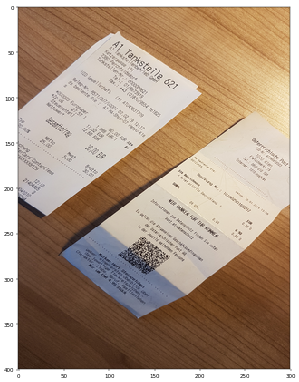

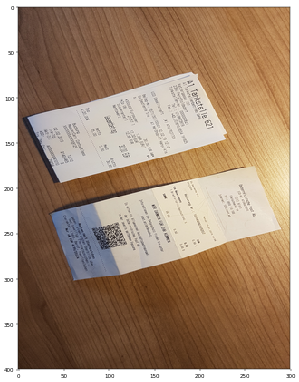

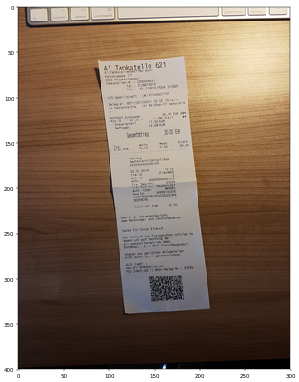

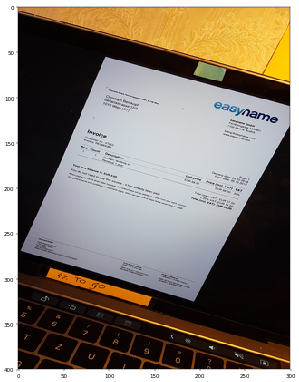

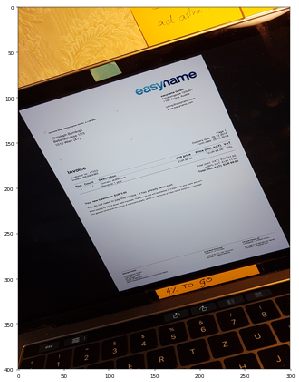

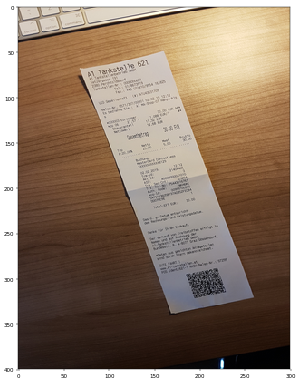

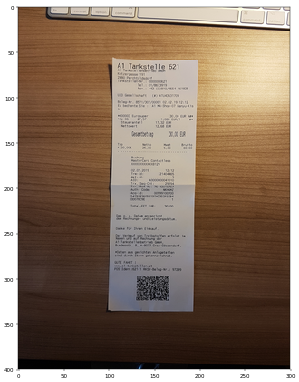

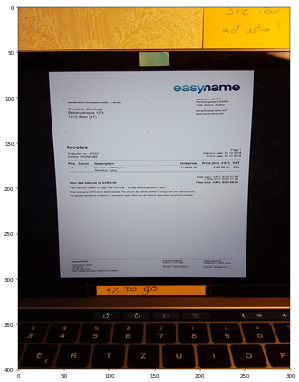

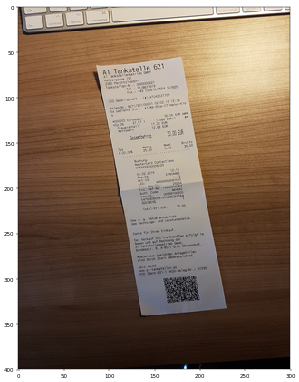

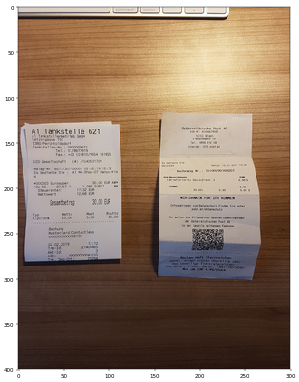

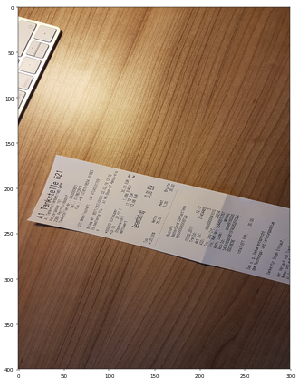

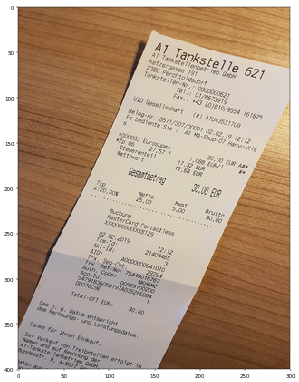

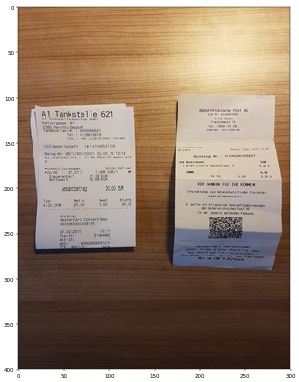

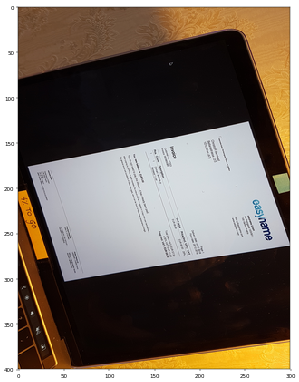

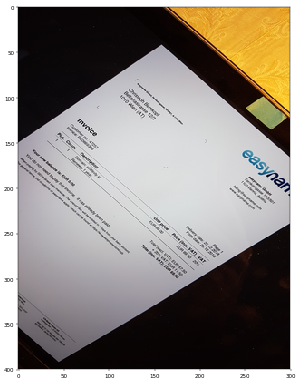

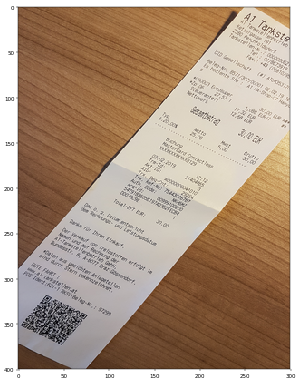

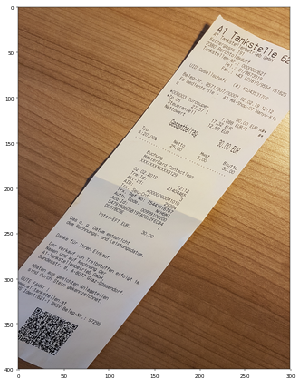

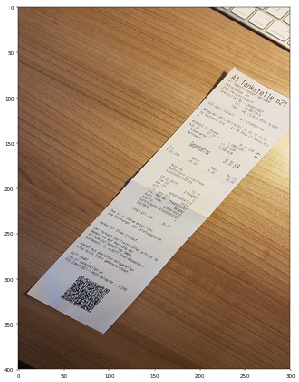

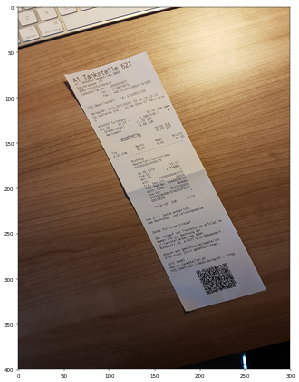

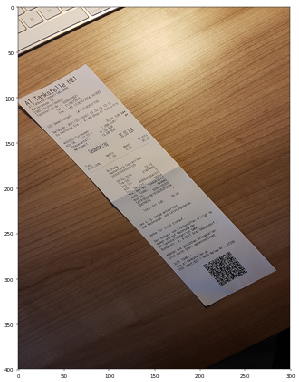

In [391]:
imgs = []
for img_name in tqdm(real_rotated_image_names):
    curr_img = get_real_img_tensor(real_rotated_folder, img_name, max_img_size_x, max_img_size_y)
    curr_img = np.expand_dims(curr_img, axis=0)

    if(len(imgs) == 0):
        imgs = curr_img
    else:
        imgs = np.concatenate([imgs,curr_img], axis=0)

imgs = torch.tensor(imgs).float()
imgs.shape

In [286]:
def pred_img(imgs):
    outputs = model(imgs)
    if type(outputs) == tuple:
        outputs, _ = outputs
    _, preds = torch.max(outputs.data, 1)
    return preds

In [343]:
preds = pred_img(imgs)
print(preds)

tensor([75, 90, 46, 58, 26, 30, 46, 46, 41, 46, 58, 59, 46, 90, 80, 74, 74, 73,
        30, 75])


100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


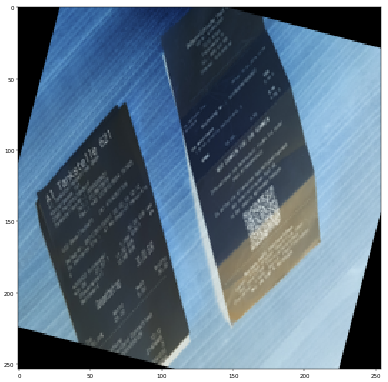

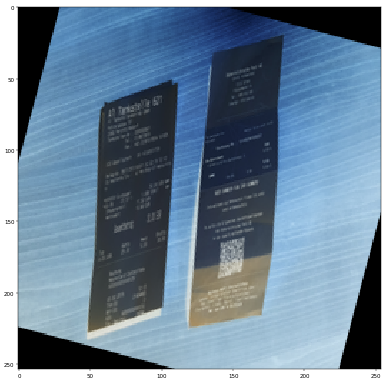

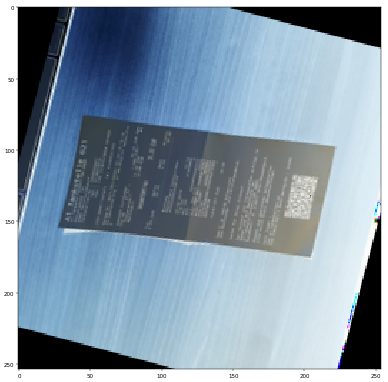

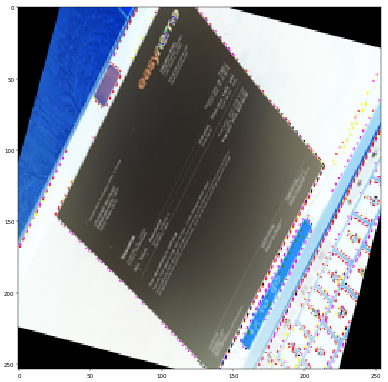

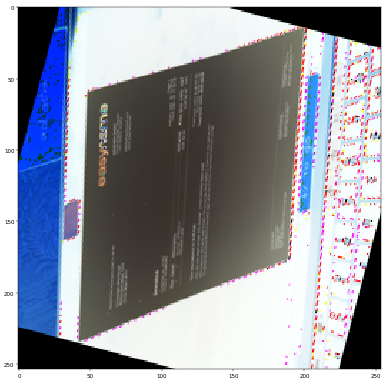

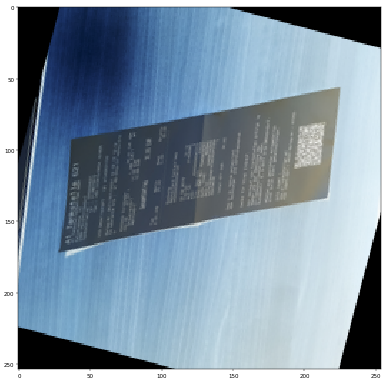

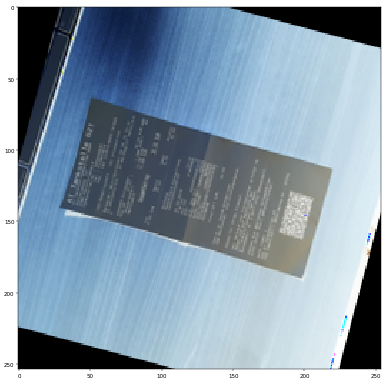

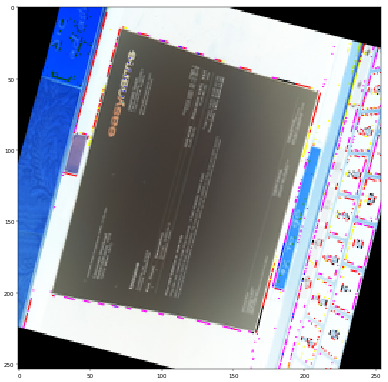

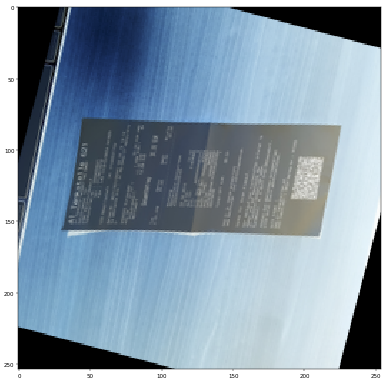

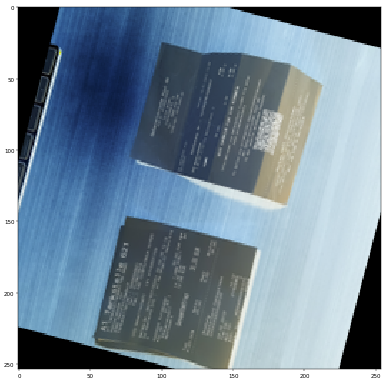

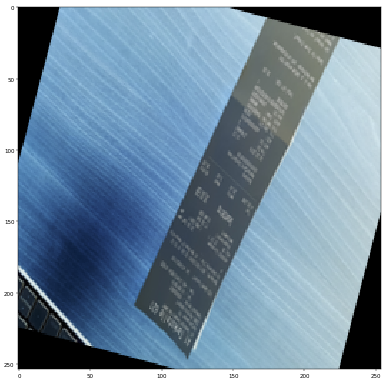

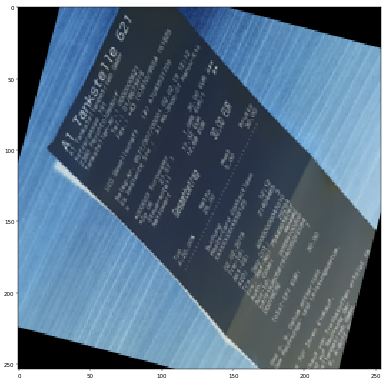

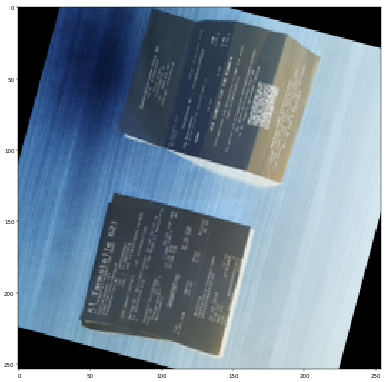

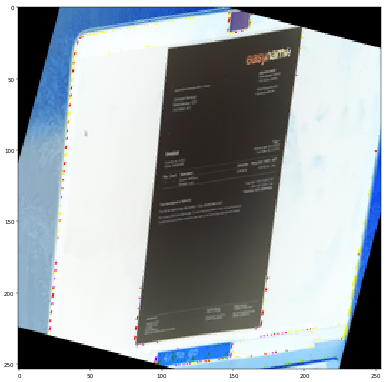

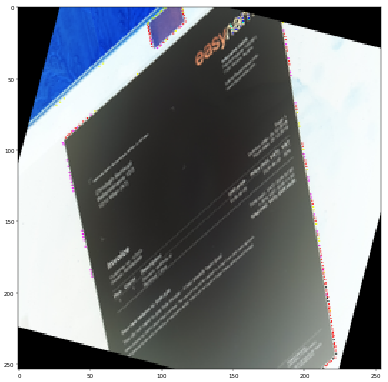

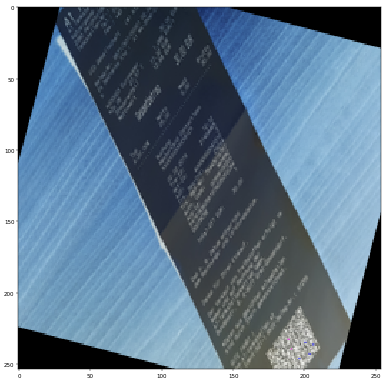

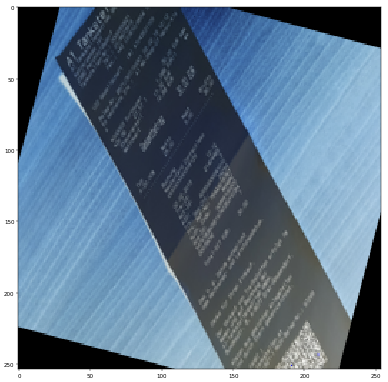

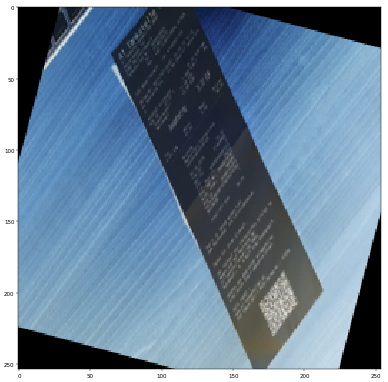

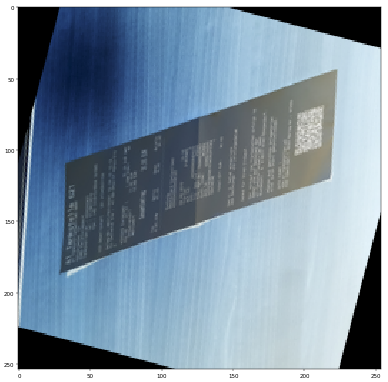

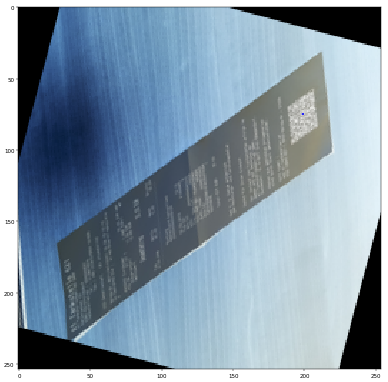

In [372]:
for img_name in tqdm(real_rotated_image_names):
    curr_img = get_real_img_tensor(real_rotated_folder, img_name, max_img_size_x, max_img_size_y, False)
    curr_img.shape
    img = correct_image_rot(curr_img, int(preds[0]))
    img_show(img, 12)